In [2]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
file_source = 'gdrive/MyDrive/Kaggle/Quora_Q_Pairs/'

In [59]:
train_df = pd.read_csv('gdrive/MyDrive/Kaggle/Quora_Q_Pairs/train.csv')

In [60]:
test_df = pd.read_csv('gdrive/MyDrive/Kaggle/Quora_Q_Pairs/test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [20]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import keras

In [7]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

wv.save(file_source + '/vectors.kv')

[=================================================-] 99.6% 1656.3/1662.8MB downloaded


In [6]:
from gensim.models import KeyedVectors


reloaded_word_vectors = KeyedVectors.load(file_source + '/vectors.kv')

In [7]:
# a
wv = reloaded_word_vectors

In [25]:
import nltk

In [26]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [53]:
# stops = set(stopwords.words('english'))
wh_words = ['who', 'what', 'when', 'why', 'how', 'which', 'where', 'whom']
stops = set(stopwords.words('english'))
for word in wh_words:
    stops.remove(word)

In [58]:
# stops = set(stopwords.words('english'))

def text_cleanup(text,lemmatization = True):
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    # text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = text.split()

    if lemmatization == True:
        lem = WordNetLemmatizer()
        corpus = [lem.lemmatize(x, pos = 'v') for x in text]

    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
# from nltk.stem.porter import PorterStemmer 
# from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


In [55]:

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding

In [56]:
word2vec  = wv

In [61]:
questions_cols = ['question1', 'question2']

for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        for question in questions_cols:

            for word in text_cleanup(row[question]):

                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            dataset.at[index, question] =  q2n
            # break
        # break
    # break
            # , q2n)

In [62]:
import pickle
# Dump processed list to file for future re-use
with open(file_source + '/train_df', 'wb') as fp:
    pickle.dump(train_df, fp)
with open(file_source + '/test_df', 'wb') as fp:
    pickle.dump(test_df, fp)


# Read back processed list from file at a later time
# with open (file_source + '/outfile', 'rb') as fp:
#     all_corpus = pickle.load(fp)

In [61]:
train_df.shape,test_df.shape
# ((404290, 6), (3563475, 3))

((404290, 6), (3563475, 3))

In [63]:
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim) 
embeddings[0] = 0

for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

In [64]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

Y_train = Y_train.values
Y_validation = Y_validation.values

for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [65]:
n_hidden = 50
batch_size = 512
n_epoch = 3

def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# logistic_layer = keras.layers.Dense(1, input_shape=(1,), activation='sigmoid')

malstm = Model([left_input, right_input], [malstm_distance])

In [ ]:
# lr_schedule = keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-2 * 10**(epoch))
# optimizer_Adam_updated = keras.optimizers.Adam(learning_rate=1e-2)
# # keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# # filepath=file_source + "/weights-improvement-deca-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# # checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# # callbacks_list = [checkpoint,lr_schedule]
# malstm.compile(loss="mse", optimizer=optimizer_Adam_updated,metrics=['accuracy'])
# malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=100,
#                             validation_data=([X_validation['left'], X_validation['right']], Y_validation),callbacks = lr_schedule)

In [67]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

optimizer_Adam = keras.optimizers.Adam(learning_rate=0.1)

In [32]:
filepath=file_source + "/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [33]:
# optimizer = Adadelta(learning_rate=0.01)

malstm.compile(loss='mean_squared_error', optimizer=optimizer_Adam, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation),callbacks = callbacks_list)

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/10
712/712 [==============================] - 1538s 2s/step - loss: 0.1708 - accuracy: 0.7553 - val_loss: 0.1435 - val_accuracy: 0.8003

Epoch 00001: val_accuracy improved from -inf to 0.80032, saving model to gdrive/MyDrive/Kaggle/Quora_Q_Pairs/weights-improvement-01-0.80.hdf5
Epoch 2/10
712/712 [==============================] - 1511s 2s/step - loss: 0.1384 - accuracy: 0.8101 - val_loss: 0.1387 - val_accuracy: 0.8065

Epoch 00002: val_accuracy improved from 0.80032 to 0.80650, saving model to gdrive/MyDrive/Kaggle/Quora_Q_Pairs/weights-improvement-02-0.81.hdf5
Epoch 3/10
712/712 [==============================] - 1462s 2s/step - loss: 0.1316 - accuracy: 0.8215 - val_loss: 0.1344 - val_accuracy: 0.8143

Epoch 00003: val_accuracy improved from 0.80650 to 0.81430, saving model to gdrive/MyDrive/Kaggle/Quora_Q_Pairs/weights-improvement-03-0.81.hdf5
Epoch 4/10
712/712 [==============================] - 1470s 2s/step - loss: 0.1259 - accuracy: 0.8303 - val_loss: 0.1324 - val_accura

In [ ]:
# filepath=file_source + "/weights-improvement-second_training-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

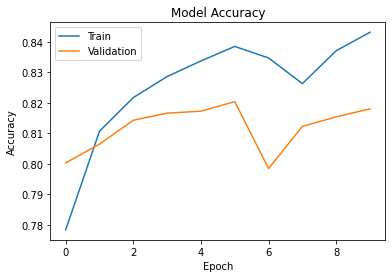

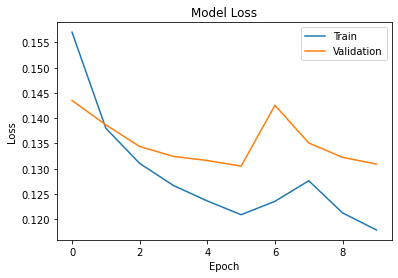

In [36]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [43]:
# Load saved weights and then compile to make it ready for further training or predictions
malstm.load_weights("gdrive/MyDrive/Kaggle/Quora_Q_Pairs/weights-improvement-06-0.82.hdf5", by_name = True)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


## Making predictions on validation set
preds = malstm.predict([X_validation['left'], X_validation['right']])
y_pred = [1 if x > 0.5 else 0 for x in preds] 

In [57]:
TN = 0
FN =0
TP =0
FP = 0

for index in range(len(y_pred)):
  if Y_validation[index] == 0:
    if y_pred[index] == Y_validation[index]:
      TN +=1
    else:
      FN +=1
  else:
    if y_pred[index] == Y_validation[index]:
      TP +=1
    else:
      FP +=1

In [58]:
TP,TN,FP,FN

(10408, 22408, 4430, 2754)

In [59]:
Precision = (TP)/(TP+FP)
Recall = (TP)/(TP+FN)
Precision,Recall

(0.7014422428898773, 0.7907612824798663)